In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import pyemma as pye
import glob
%matplotlib inline
%matplotlib ipympl
import matplotlib.pyplot as plt
import matplotlib
import mdtraj
import nglview
matplotlib.__version__

_ColormakerRegistry()

'3.1.0'

In [3]:
path=os.path.join('/Volumes/Vikas\'s Drive','Trajectories_processed','POPC')
traj_files = glob.glob(path + "/*.xtc") 
pdb_files = glob.glob(path + "/*.pdb")
traj_files[-2]

"/Volumes/Vikas's Drive/Trajectories_processed/POPC/combined_backbone.xtc"

In [10]:
NTD=np.arange(0,3275).reshape(1,-1)
nonNTD=np.arange(4075,19435).reshape(1,-1)
atom_indices=np.hstack((NTD,nonNTD))


In [14]:
atom_indices.shape

(1, 18635)

## Feature Selection

In [11]:
feature = pye.coordinates.featurizer(pdb_files[1])
feature.add_minrmsd_to_ref(ref_frame=0, ref=pdb_files[1],atom_indices=atom_indices)
reader = pye.coordinates.source(traj_files[-2], features=feature)

## load saved data

In [12]:
RMSD_obj=reader.get_output()

ValueError: atom_indices must be ndim 1. You supplied 2

In [1]:
RMSD_obj_conc=np.concatenate(RMSD_obj)
with open('RMSD-NTD-POPC.dat','w') as f:
    np.savetxt(f,RMSD_obj_conc)

NameError: name 'np' is not defined

In [110]:
RMSD_obj_conc

array([[0.00077225],
       [0.14601293],
       [0.15974058],
       ...,
       [0.29316115],
       [0.29723701],
       [0.29924762]])

In [4]:
RMSD_obj_conc=np.genfromtxt('rmsd.xvg')
RMSD_obj_conc=RMSD_obj_conc[:,1]
RMSD_obj_conc=RMSD_obj_conc.reshape(-1,1)

Text(0.5, 0, 'RMSD(nm)')

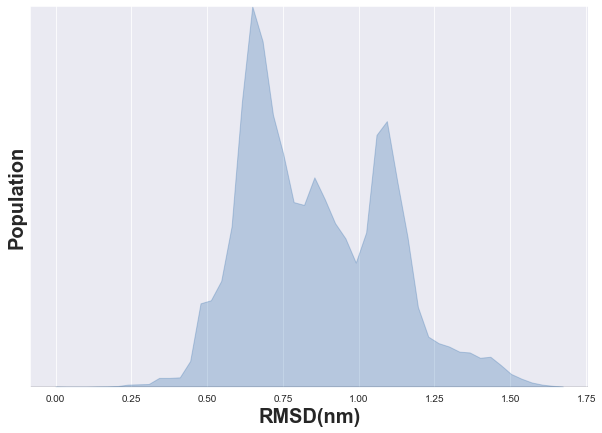

In [5]:
diverging_colors = sns.color_palette("RdBu", 10)
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 1, figsize=(10, 7))
pye.plots.plot_feature_histograms(RMSD_obj_conc, feature_labels=np.arange(0,1).tolist(), ax=axes,color=diverging_colors[9],)
#plt.xticks( np.arange(0,2), size=20)
plt.ylabel('Population', size=20, weight='bold')
plt.yticks([],size=20)
plt.xlabel( 'RMSD(nm)',size=20, weight='bold')

In [77]:
from sklearn.cluster import KMeans
convergence_kmeans=[]
for i in range(2,30):
    kmeans=KMeans(n_clusters=i, random_state=0).fit(RMSD_obj_conc)
    convergence_kmeans.append(kmeans.inertia_)

In [78]:
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
plt.plot(convergence_kmeans, marker='o',ms=15, lw=2, markerfacecolor=diverging_colors[5])
plt.xticks( np.arange(0,30,5), np.arange(90,130,5), size=20)
plt.ylabel('Reduction in variation', size=20, weight='bold')
plt.yticks(size=20)
plt.xlabel('Number of clusters', size=20, weight='bold')

/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'Number of clusters')

In [107]:
cluster = pye.coordinates.cluster_kmeans(RMSD_obj_conc, k=500, max_iter=200)
dtrajs = cluster.dtrajs

In [108]:
lags = [1,10,25, 50, 100, 250 , 300, 400, 500,750, 1000,1200, 1500,1750,2000,3000]
its = pye.msm.its(dtrajs, lags=lags, errors='bayes')

In [109]:
fig, axes = plt.subplots(figsize=(25,12))
pye.plots.plot_implied_timescales(its, marker='o', ms=20, lw=2, markerfacecolor=diverging_colors[5], nits=4 )

plt.xticks(size=30)
plt.xlabel('lagtime/step', size=30, weight='bold')
plt.yticks(size=30)
plt.ylabel('Timescale/steps', size=30, weight='bold')

/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'Timescale/steps')

## MSM estimation

In [116]:
M = pye.msm.estimate_markov_model(dtrajs,250)

In [117]:
len(dtrajs[0])

73911

In [118]:
print('fraction of states used = {:f}'.format(M.active_state_fraction))
print('fraction of counts used = {:f}'.format(M.active_count_fraction))

fraction of states used = 0.996000
fraction of counts used = 1.000000


In [119]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(figsize=(10,7))
plt.plot(M.timescales(),linewidth=0,marker='o',ms=15,markerfacecolor=diverging_colors[2])
plt.xlabel('index', size=20,weight='bold')
plt.ylabel('timescale', size=20, weight='bold')
plt.xlim(-0.5,10.5)
plt.xticks(size=20)
plt.xlabel('lagtime/step', size=30, weight='bold')
plt.yticks(size=20)

/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.,
        4000.]), <a list of 10 Text yticklabel objects>)

In [120]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(figsize=(10,7))
plt.plot(M.timescales()[:-1]/M.timescales()[1:], linewidth=0,marker='o', ms=15,markerfacecolor=diverging_colors[2])
plt.xlabel('index', size=20,weight='bold')
plt.ylabel('timescale separation', size=20, weight='bold')
plt.xlim(-0.5,10.5)
plt.xticks(size=20)
plt.yticks(size=20)

/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Text yticklabel objects>)

In [121]:
sns.set_style('darkgrid')
n_sets = 3
ck = M.cktest(n_sets, mlags=10, err_est=True, show_progress=True)

plt.rcParams.update({'font.size': 20})
pye.plots.plot_cktest(ck, diag=False, figsize=(10,10),layout=(n_sets,n_sets), padding_top=0.1, dt=0.04, y01=True, padding_between=0.3, units='ns')


/anaconda2/envs/py36/lib/python3.6/site-packages/pyemma/plots/markovtests.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(layout[0], layout[1], sharex=True, sharey=sharey, figsize=figsize)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(<Figure size 720x720 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1a3c4160>,
       dtype=object))

In [122]:
for i, s in enumerate(M.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, M.pi[s].sum()))

π_1 = 0.347899
π_2 = 0.218764
π_3 = 0.433337


In [124]:
hmm = M.coarse_grain(3)

In [125]:
hmm.stationary_distribution

array([0.3607, 0.2209, 0.4184])

In [126]:
np.set_printoptions(precision=4, suppress=True)
print(hmm.transition_matrix)

[[0.9591 0.0334 0.0074]
 [0.0545 0.8741 0.0714]
 [0.0064 0.0377 0.9559]]


In [127]:
RMSD_obj_conc

array([[0.    ],
       [0.1543],
       [0.1823],
       ...,
       [1.176 ],
       [1.1446],
       [1.1744]])

In [129]:
#metastable_traj = M.metastable_assignments[dtrajs]
#highest_membership = M.metastable_distributions.argmax(1)
#highest_membership_value = M.metastable_distributions.max(1)
#coarse_state_centers = cluster.clustercenters[M.active_set[highest_membership]]

sns.set_style('darkgrid')
plt.figure(figsize=(15,10))
plt.scatter(y=RMSD_obj_conc,x=range(0,len(RMSD_obj_conc)),c=metastable_traj, cmap=plt.cm.Accent)
plt.ylabel('RMSD(nm)')
plt.xlabel('Frames')
plt.title('Metastable states')
plt.colorbar(ticks=[0,1,2])

/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [130]:
metastable_traj=metastable_traj.reshape(-1,1)

In [131]:
data=np.hstack((RMSD_obj_conc,metastable_traj))
df=pd.DataFrame(data)
df.columns=['RMSD','States']
df.hist(figsize=(20,10))

/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/plotting/_tools.py:197: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1e1f42c6a0>,
      dtype=object)

In [134]:
#pos=np.array([[0,0.29],[0.49,0],[1.01,0.28]])
pos=np.array([[0.55    , 1. ],
       [0.9992, 0.0],
        [0.1304, 0.    ]])
pye.plots.plot_markov_model(hmm,state_scale=1.2,pos=pos, max_height=15, arrow_scale=1.5, arrow_curvature=2, max_width=10, arrow_labels=trans_mat, arrow_label_format='%0.1f',state_colors=[diverging_colors[2], diverging_colors[4],diverging_colors[7]])
#pye.plots.plot_markov_model(hmm)

/anaconda2/envs/py36/lib/python3.6/site-packages/pyemma/plots/networks.py:188: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = _plt.figure(None, figsize=figsize)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(<Figure size 720x828.729 with 1 Axes>, array([[0.55  , 1.    ],
        [0.9992, 0.    ],
        [0.1304, 0.    ]]))

In [135]:
trans_mat=hmm.transition_matrix
trans_mat=trans_mat*100/3
trans_mat1=trans_mat
np.fill_diagonal(trans_mat1,0)
trans_mat=(trans_mat/trans_mat1.sum())*100
trans_mat

array([[ 0.    , 15.8457,  3.531 ],
       [25.8698,  0.    , 33.8431],
       [ 3.0434, 17.8671,  0.    ]])

In [136]:
nstates=3
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = M.mfpt(
            M.metastable_sets[i],
            M.metastable_sets[j])


mfpt=(mfpt*40)/1000
MPT=pd.DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))



In [137]:
plt.figure(figsize=(10,7))

sns.heatmap(data=MPT,lw=5, annot=True,fmt="0.2f", cmap='Spectral_r',alpha=0.9,cbar_kws={'label':'First mean passage time(ns)','orientation':'horizontal'})
plt.xticks(np.arange(0.5,3.5),['State2','State1','State3'], weight='bold')
plt.yticks(np.arange(0.5,3.5),['State2','State1','State3'], rotation=0, weight='bold')

/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

([<matplotlib.axis.YTick at 0x1a1dc5a8d0>,
 <a list of 3 Text yticklabel objects>)

In [138]:
pcca_samples = M.sample_by_distributions(M.metastable_distributions,100)

In [ ]:
outfiles = []
for k in range(0, 3):
    intstring = str(k+1)
    filename = 'samples_pcca_RMSD'+ intstring + '.xtc'
    outfiles.append(filename)

pye.coordinates.save_trajs(reader, pcca_samples, outfiles = outfiles)

In [ ]:
vis_set = 3
traj_sample = mdtraj.load_xtc('samples_pcca_RMSD'+ str(vis_set) + '.xtc', top=pdb_files[1], stride = 1)
w = nglview.show_mdtraj(traj_sample)
w.clear_representations()
w.add_representation('cartoon', selection='all', color_scheme = 'hydrophobicity')
w